## Librerías

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2024-01-24 16:43:39.736426: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 16:43:39.736453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 16:43:39.739928: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 16:43:40.071052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [2]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-01-24 16:43:43.688877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 16:43:43.742080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 16:43:43.742233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Datos

In [3]:
## Obtener todas las rutas de las imágenes en el dataset
ruta = '../Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg'
rutas_dataset  = glob.glob('../../../Datasets/Micrografías segmentaciones/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:    
    ruta_list = ruta.split('/')       
    clase = ruta_list[6]
    number = ruta_list[7]
    tipo = ruta_list[8]
    name = ruta_list[9].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', np.shape(routes_dataset[routes_dataset['label']=='MF1'])[0])
print('MF2:', np.shape(routes_dataset[routes_dataset['label']=='MF2'])[0])
print('MF3:', np.shape(routes_dataset[routes_dataset['label']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['label'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 923
MF1: 378
MF2: 284
MF3: 261


,name,route_image,label,number,route_mask
434,IMG_20230707_191350_jpg,../../../Datasets/Micrografías segmentaciones/...,0,7,../../../Datasets/Micrografías segmentaciones/...
57,IMG_20230602_212610_jpg,../../../Datasets/Micrografías segmentaciones/...,2,3,../../../Datasets/Micrografías segmentaciones/...
219,IMG_20230707_170826_jpg,../../../Datasets/Micrografías segmentaciones/...,0,3,../../../Datasets/Micrografías segmentaciones/...
825,IMG_20230711_212440_jpg,../../../Datasets/Micrografías segmentaciones/...,2,7,../../../Datasets/Micrografías segmentaciones/...
632,IMG_20230711_170047_jpg,../../../Datasets/Micrografías segmentaciones/...,1,4,../../../Datasets/Micrografías segmentaciones/...
...,...,...,...,...,...
101,IMG_20230707_161734_jpg,../../../Datasets/Micrografías segmentaciones/...,0,1,../../../Datasets/Micrografías segmentaciones/...
227,IMG_20230707_170928_jpg,../../../Datasets/Micrografías segmentaciones/...,0,3,../../../Datasets/Micrografías segmentaciones/...
59,IMG_20230602_212752_jpg,../../../Datasets/Micrografías segmentaciones/...,2,3,../../../Datasets/Micrografías segmentaciones/...
347,IMG_20230707_180803_jpg,../../../Datasets/Micrografías segmentaciones/...,0,5,../../../Datasets/Micrografías segmentaciones/...


In [4]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='0'])))
thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='1'])))
thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset.label == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset.label == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset.label == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset.label == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=100).reset_index(drop=True)

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  228 , test:  56
Clase MF3: train:  209 , test:  52


In [5]:
## Function to get contours and features
def get_contours_and_features(binary_map):
    # get binary map
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    # get contours from binary map
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # get features from contours
    contours_features = []
    for contour in contours:
        error = 1e-5

        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        features = {
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features    
    return contours_features

# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

# function to get tensor of one image
def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

# function to get set of binary image from image loaded
def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores

def get_geometric_atributes(binary_images):
    atributes = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)        

        ## obtener área de poros##
        area = np.ceil(np.sum(get_item(contour_features, key='area')))

        ## obtener perímetro de poros
        perimetro = np.ceil(np.sum(get_item(contour_features, key='perimeter'))
)
        ## intersticio
        area_total = np.ceil(np.shape(image)[0] * np.shape(image)[1])
        intersticio = np.ceil(area_total - area)

        ## Cantidad de poros
        poros = np.shape(contour_features)[0]

        #atributes = [area,perimetro,intersticio,poros]
        atributes.append([area,perimetro,intersticio,poros])
    
    return atributes

def create_dataset(buffer,file_names, labels, file_mask): 
  ## Get binary images   
  masks = get_binary_image(file_mask)
  ## Get geometric atributes from binary images
  attributes = get_geometric_atributes(masks)
  ## Create dataset from tensors assosiated with labels and attributes
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes))
  ## Shuffle dataset
  dataset.shuffle(buffer_size=buffer)
  ## Map dataset to load images (a = image, b = label, c = attributes, d = mask)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes))

  return dataset

file_names = train_df['route_image'].to_numpy()
file_mask = train_df['route_mask'].to_numpy()
labels = train_df['label'].to_numpy()
## Create training dataset using tf.data of 16 images
dataset = create_dataset(16,file_names, labels,file_mask)

2024-01-24 16:43:45.163179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 16:43:45.163339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 16:43:45.163444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
file_names_test = test_df['route_image'].to_numpy()
file_mask_test = test_df['route_mask'].to_numpy()
labels_test = test_df['label'].to_numpy()
## Create training dataset using tf.data of 16 images
dataset_test = create_dataset(16,file_names_test, labels_test,file_mask_test)

In [7]:
## Dataset de prueba
test_df = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_secas = []
y_test_secas = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df)):
    
    #Capturar ruta y label
    ruta = test_df.iloc[i].route_image
    label = test_df.iloc[i].label
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta,color_mode='grayscale')
    
    X_test_secas.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_secas.append(test_df.iloc[i].label)
    
print('Test: train->',np.shape(X_test_secas),' test ->',np.shape(y_test_secas))

Test: train-> (183, 128, 128, 1)  test -> (183,)


In [8]:
x_test_secas = np.array(X_test_secas)
x_test_secas= x_test_secas.astype('float32')
 
#y_test_secas = tf.keras.utils.to_categorical(y_test_secas)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_secas /= 255

print('Number of images in x_test', x_test_secas.shape, "y_test: ", np.shape(y_test_secas))

Number of images in x_test (183, 128, 128, 1) y_test:  (183,)


In [9]:
x_train = []
y_train_ten = []
for data,label,attributes in dataset.batch(8):
    x_train.extend(data[:].numpy())
    y_train_ten.extend(label)   

x_train = np.array(x_train)
x_train = x_train.astype('float32')

y_train= []
for i in y_train_ten:
    y_train.append(str(int(i)))

print(np.shape(x_train),np.shape(y_train))

(740, 128, 128, 1) (740,)


## Modelo

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
encoder = keras.models.load_model('Models/weakly2_GVAE_encoder_DRY_1_32.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('Models/weakly2_GVAE_decoder_DRY_1_32.h5', custom_objects={'Sampling':Sampling})

2024-01-24 16:44:54.623893: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.


## Visualización embebidos

In [12]:
## Media = 0, Varianza = 1, Z = 2
D = 2

## Dimensiones
dmx = 8
dmy = 4

In [13]:
data_train = x_train
data_test = x_test_secas

label_train = y_train
label_test = y_test_secas

print('Train: ',np.shape(data_train),np.shape(label_train))
print('Test: ',np.shape(data_test),np.shape(label_test))

# Embebidos del encoder
encoder_embds  = encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

Train:  (740, 128, 128, 1) (740,)
Test:  (183, 128, 128, 1) (183,)


2024-01-24 16:44:55.111775: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48496640 exceeds 10% of free system memory.
2024-01-24 16:44:55.169425: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48496640 exceeds 10% of free system memory.
2024-01-24 16:44:55.539975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-01-24 16:44:56.155579: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-24 16:44:56.157032: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available

24/24 [==============================] - 4s 86ms/step
Shape_embs:  (3, 740, 32)
6/6 [==============================] - 1s 239ms/step
Shape_embs:  (3, 183, 32)


In [14]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs = decoder.predict(encoder_embds[D])
print(np.shape(autoencoder_imgs),np.shape(encoder_embds))

24/24 [==============================] - 1s 8ms/step
(740, 128, 128, 1) (3, 740, 32)


2024-01-24 16:45:01.500525: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48496640 exceeds 10% of free system memory.


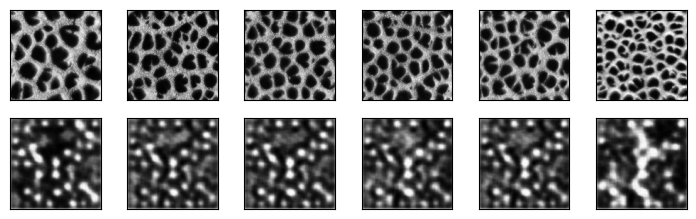

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(30, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)    
    plt.imshow(data_train[i].reshape(128,128,1))
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
    
    # display reconstruction
    ax = plt.subplot(3, 20, 1*20 +i+ 1)    
    plt.imshow(autoencoder_imgs[i].reshape(128,128,1))    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()
plt.tight_layout()

In [16]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs_test = decoder.predict(encoder_embds_test[D])
print(np.shape(autoencoder_imgs_test),np.shape(encoder_embds_test))

6/6 [==============================] - 0s 22ms/step
(183, 128, 128, 1) (3, 183, 32)


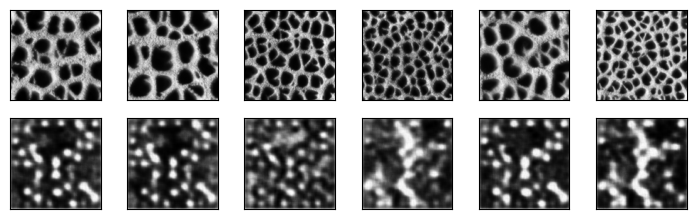

In [17]:
plt.figure(figsize=(30, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)       
    
    # display reconstruction
    ax = plt.subplot(3, 20, 1*20 +i+ 1)
    plt.imshow(autoencoder_imgs_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

### PCA

In [18]:
labels_text_test = pd.DataFrame(label_test).replace({'0': "MF1", '1': "MF2",'2': "MF3"})
labels_text_test.shape

(183, 1)

In [19]:
pca_data_test = PCA(n_components=2)
PCA_2dim_test = pca_data_test.fit_transform(encoder_embds_test[D])
PCA_2dim_test.shape

(183, 2)

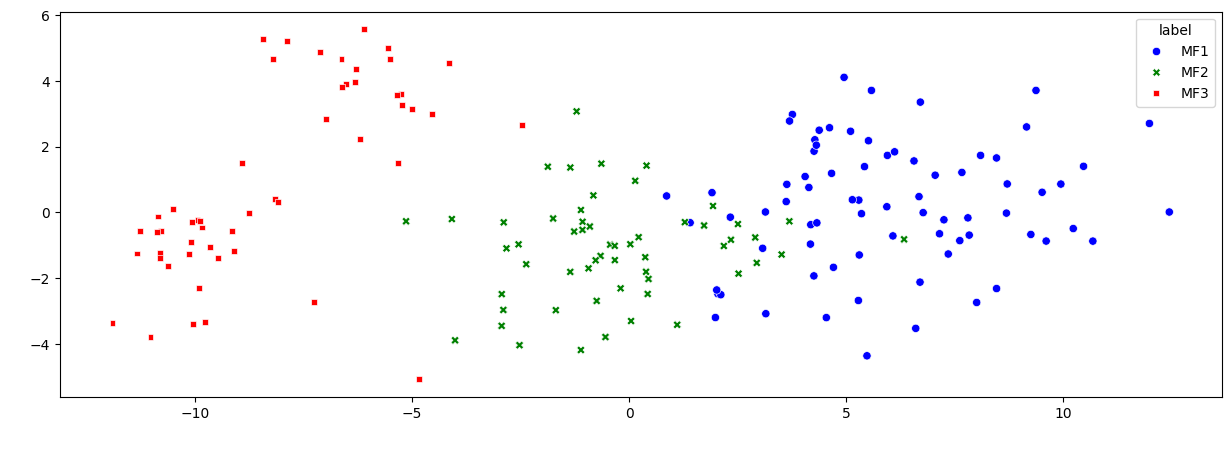

In [20]:
data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim_test[:,0]
data_img_pca_test['y'] = PCA_2dim_test[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,style='label',
            sizes=(60, 100), alpha=1, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

## Distancia entre embebidos

In [21]:
embebidos = pd.DataFrame()
embebidos['vectores'] = list(encoder_embds_test[D])
embebidos['etiquetas'] = labels_text_test

embebidos

,vectores,etiquetas
0,"[-5.038905, -3.6946375, -5.029455, 2.442069, -...",MF1
1,"[-6.787097, -0.7502937, -4.293367, 1.222416, -...",MF1
2,"[-5.1033263, -2.7561436, -2.9596126, 4.0604773...",MF2
3,"[-2.000685, -3.1557403, -1.4002922, 5.303246, ...",MF3
4,"[-3.7190046, -2.6542616, -4.5044794, 3.4003608...",MF1
...,...,...
178,"[-2.8932004, -3.353576, -2.5835345, 5.391794, ...",MF3
179,"[-2.9349866, -3.7872696, -1.1813744, 4.6679606...",MF3
180,"[-3.4615426, -2.173359, -4.1132874, 2.5073767,...",MF1
181,"[-2.4535892, -3.78748, -2.055132, 3.8338535, 3...",MF2


In [22]:
## Separar los embebidos por clases
embebidos_A = embebidos[embebidos.etiquetas == 'MF1'].reset_index()
embebidos_B = embebidos[embebidos.etiquetas == 'MF2'].reset_index()
embebidos_C = embebidos[embebidos.etiquetas == 'MF3'].reset_index()

In [23]:
def cluster_distances(vect_1,conjunto):
    dist = []
    for d in range(len(conjunto)):
        vect_2 = conjunto.vectores[d]
        dst = np.sqrt(np.sum((vect_1 - vect_2)**2))
        if dst != 0:
            dist.append(dst)
    return dist

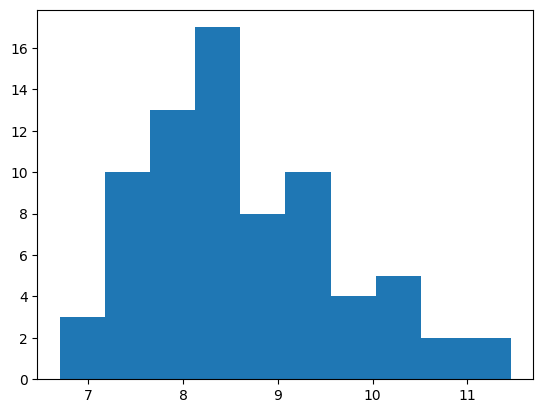

In [24]:
vect_1 = embebidos_A.vectores[0]
conjunto = embebidos_A
dist = cluster_distances(vect_1,conjunto)
plt.hist(dist)
plt.show()

In [25]:
distances_A = []
for i in range(len(embebidos_A)-1):
    vect_1 = embebidos_A.vectores[i]    
    distances_A += cluster_distances(vect_1,embebidos_A)   


distances_B = []
for i in range(len(embebidos_B)-1):
    vect_1 = embebidos_B.vectores[i]    
    distances_B += cluster_distances(vect_1,embebidos_B)

distances_C = []
for i in range(len(embebidos_C)-1):
    vect_1 = embebidos_C.vectores[i]    
    distances_C += cluster_distances(vect_1,embebidos_C) 

### WSS

Distancias medias:
MF1:  7.7440557 , Color: Rojo
MF2:  5.8573804 , Color: Verde
MF3:  5.6998043 , Color: Azul


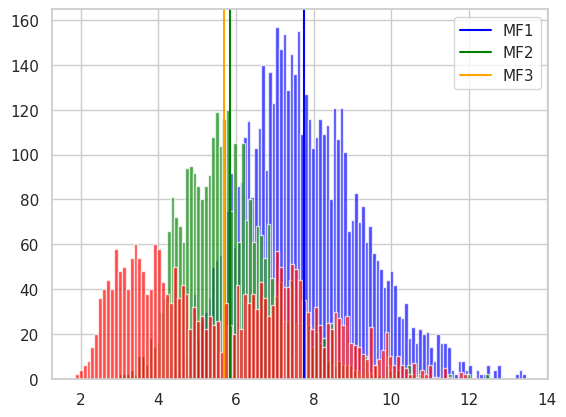

In [26]:
sns.set_theme()
sns.set_style("whitegrid")
plt.hist(distances_A,bins=100,color='blue',alpha = 0.7)
plt.axvline(x = np.mean(distances_A), color = 'blue', label = 'MF1')
plt.hist(distances_B,bins=100,color='green',alpha = 0.7)
plt.axvline(x = np.mean(distances_B), color = 'green', label = 'MF2')
plt.hist(distances_C,bins=100,color='red',alpha = 0.7)
plt.axvline(x = np.mean(distances_C), color = 'orange', label = 'MF3')
print('Distancias medias:')
print('MF1: ',np.mean(distances_A),', Color: Rojo')
print('MF2: ',np.mean(distances_B),', Color: Verde')
print('MF3: ',np.mean(distances_C),', Color: Azul')
plt.legend()
plt.show()

### BSS

Distancias medias:
MF1 -> MF2:  9.136346 , Color: Azul
MF1 -> MF3:  15.451592 , Color: Verde
MF1:  7.7440557 , Color: Rojo


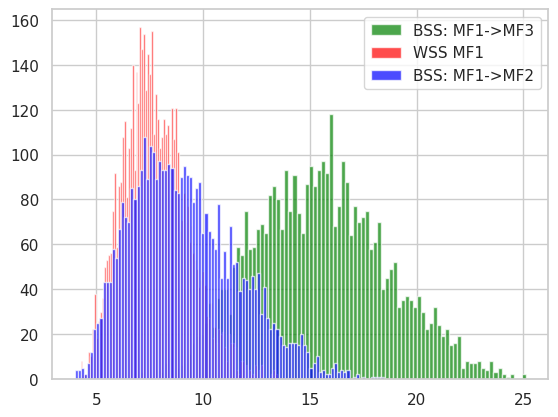

In [31]:
distances_A_B = []
for i in range(len(embebidos_A)-1):
    vect_1 = embebidos_A.vectores[i]    
    distances_A_B += cluster_distances(vect_1,embebidos_B) 

distances_A_C = []
for i in range(len(embebidos_A)-1):
    vect_1 = embebidos_A.vectores[i]    
    distances_A_C += cluster_distances(vect_1,embebidos_C) 




plt.hist(distances_A_C,bins=100,color='green',alpha = 0.7,label = 'BSS: MF1->MF3')



plt.hist(distances_A,bins=100,color='red',alpha = 0.7, label = 'WSS MF1')

plt.hist(distances_A_B,bins=100,color='blue',alpha = 0.7,label = 'BSS: MF1->MF2')



print('Distancias medias:')
print('MF1: ',np.mean(distances_A),', Color: Rojo')

print('MF1 -> MF2: ',np.mean(distances_A_B),', Color: Azul')

print('MF1 -> MF3: ',np.mean(distances_A_C),', Color: Verde')


plt.legend()
plt.show()

Distancias medias:
MF2:  5.8573804 , Color: Rojo
MF2 -> MF1:  9.136346 , Color: Azul
MF2 -> MF3:  15.451592 , Color: Verde


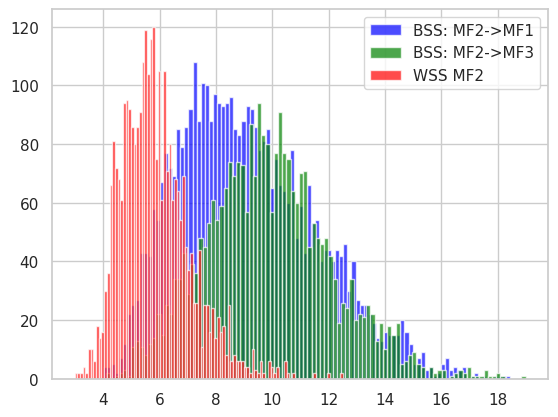

In [28]:
distances_B_A = []
for i in range(len(embebidos_B)-1):
    vect_1 = embebidos_B.vectores[i]    
    distances_B_A += cluster_distances(vect_1,embebidos_A) 

distances_B_C = []
for i in range(len(embebidos_B)-1):
    vect_1 = embebidos_B.vectores[i]    
    distances_B_C += cluster_distances(vect_1,embebidos_C) 


plt.hist(distances_B_A,bins=100,color='blue',alpha = 0.7,label = 'BSS: MF2->MF1')

plt.hist(distances_B_C,bins=100,color='green',alpha = 0.7,label = 'BSS: MF2->MF3')

plt.hist(distances_B,bins=100,color='red',alpha = 0.7,label = 'WSS MF2')


print('Distancias medias:')
print('MF2: ',np.mean(distances_B),', Color: Rojo')

print('MF2 -> MF1: ',np.mean(distances_A_B),', Color: Azul')

print('MF2 -> MF3: ',np.mean(distances_A_C),', Color: Verde')

plt.legend()
plt.show()

Distancias medias:
MF3:  5.6998043 , Color: Rojo
MF3 -> MF1:  15.518448 , Color: Azul
MF3 -> MF2:  9.905653 , Color: Verde


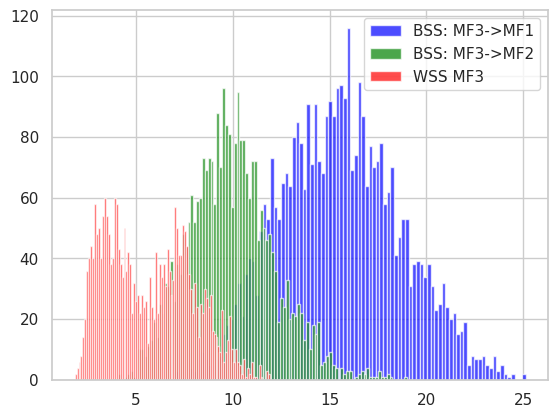

In [32]:
distances_C_A = []
for i in range(len(embebidos_C)-1):
    vect_1 = embebidos_C.vectores[i]    
    distances_C_A += cluster_distances(vect_1,embebidos_A) 

distances_C_B = []
for i in range(len(embebidos_C)-1):
    vect_1 = embebidos_C.vectores[i]    
    distances_C_B += cluster_distances(vect_1,embebidos_B) 


plt.hist(distances_C_A,bins=100,color='blue',alpha = 0.7,label = 'BSS: MF3->MF1')

plt.hist(distances_C_B,bins=100,color='green',alpha = 0.7, label = 'BSS: MF3->MF2')

plt.hist(distances_C,bins=100,color='red',alpha = 0.7, label= 'WSS MF3')

print('Distancias medias:')
print('MF3: ',np.mean(distances_C),', Color: Rojo')

print('MF3 -> MF1: ',np.mean(distances_C_A),', Color: Azul')

print('MF3 -> MF2: ',np.mean(distances_C_B),', Color: Verde')

plt.legend()
plt.show()